In [1]:
import sympy, sympy.abc
import numpy as np
import matplotlib.pyplot as plt

For this week's programming homework we use [SymPy](https://www.sympy.org/), a Python library for symbolic mathematics. It is installed on Google Colab. Run `pip install sympy` or similar to install it on your machine if you prefer not to work online.

# Modular Mathematics

Reed-Solomon codes are based on arithmetic in $\mathbb F_q = \{0,1,\dots,q-1\}$. For your convenience, we provide you with some functions that wrap SymPy's functionality to deal with this, so that you don't have to spend any time reading the SymPy manual. **You can ignore the following code: Just run it and see right below for instructions how to use it.**

In [2]:
from collections.abc import Iterable


def equals_mod(x, y, q):
    F = sympy.GF(q)
    if not isinstance(x, Iterable):
        x, y = [x], [y]
    return list(map(F, x)) == list(map(F, y))


class Poly:
    def __init__(self, p):
        assert isinstance(p, sympy.Poly)
        self.p = p

    def __repr__(self):
        return repr(self.p.as_expr())

    def __eq__(self, other):
        return self.p.domain == other.p.domain and self.p == other.p

    def __add__(self, other):
        return Poly(self.p + other.p)

    def __sub__(self, other):
        return Poly(self.p - other.p)

    def __mul__(self, other):
        return Poly(self.p * other.p)

    def __mod__(self, other):
        return Poly(sympy.rem(self.p, other.p, domain=self.p.domain))

    def __call__(self, x):
        return self.p(self.p.domain(x))

    def coeffs(self, N):
        assert self.p.degree() < N, f"Polynomial has more than {N} coefficients."
        result = self.p.all_coeffs()[::-1]
        return result + [0] * (N - len(result))


def poly_from_coeffs(coeffs, q):
    return Poly(sympy.Poly(coeffs[::-1], sympy.abc.Z, domain=sympy.GF(q)))


def poly_from_degrees_and_coeffs(degrees, coeffs, q):
    dct = {d: c for d, c in zip(degrees, coeffs)}
    return Poly(sympy.Poly(dct, sympy.abc.Z, domain=sympy.GF(q)))


def poly_from_string(s, q):
    return Poly(sympy.sympify(s).as_poly(sympy.abc.Z, domain=sympy.GF(q)))


def linear_solve_mod(M, b, q):
    M = sympy.Matrix(M, domain=sympy.GF(q))
    b = sympy.Matrix([b], domain=sympy.GF(q)).T
    assert M.rows == M.cols, "Square matrix expected"
    x = M.inv_mod(q) @ b
    return [c % q for c in x]


def det_mod(M, q):
    return sympy.GF(q)(sympy.Matrix(M).det())

Here follows the documentation.
**If you have trouble using the above code please do not hesitate to ask Freek or me by email or in person.**

## Comparing numbers or lists of numbers

Given two numbers or lists of numbers, you can use the `equals_mod` function to compare them modulo $q$:

In [3]:
assert equals_mod(2, -3, q=5)
assert equals_mod([2, 3], [-5, -4], q=7)

## Polynomials
There are three ways to **create polynomials**, namely by specifying
1. a list of coefficients (in the same order as discussed in class: the constant coefficient goes first)
2. a list of degrees and a list of coefficients
3. a string

as well as $q$, the size of $\mathbb F_q$. The third option is mostly useful for debugging.

The following code creates the polynomial $1 - X^2$ for $q=3$ in the three different ways:

In [4]:
A = poly_from_coeffs([1, 0, -1], q=3)
B = poly_from_degrees_and_coeffs([0, 2], [1, -1], q=3)
C = poly_from_string("1 - Z**2", q=3)
assert A == B == C

You can **add**, **subtract**, and **multiply** polynomials just like you would expect:

In [5]:
A = poly_from_string("1", q=5)
B = poly_from_string("Z - 1", q=5)
C = poly_from_string("Z", q=5)
D = poly_from_string("Z**2 - Z", q=5)
assert A + B == C and C - B == A and A * B * C == D

Likewise, to compute the **remainder** of $A$ divided by $B$:

In [6]:
A = poly_from_string("2*Z**2 + Z**4", q=5)
B = poly_from_string("Z**2 + 4*Z", q=5)
assert A % B == poly_from_string("3*Z", q=5)

You can also **evaluate** polynomials, i.e., compute $P(x)$ for some $x$, in the obvious way:

In [7]:
P = poly_from_string("Z**2 - 5", q=7)
P(2)

-1

Finally, you can extract the polynomial's **coefficients** as follows. The parameter specifies how many coefficients to extract (starting with the constant term):

In [8]:
P = poly_from_string("3 * Z**2 - 2 * Z + 1", q=7)
P.coeffs(10)

[1, -2, 3, 0, 0, 0, 0, 0, 0, 0]

## Linear Equations

We also provide you with some means of dealing a system of **linear equations** modulo $q$.
We will only be interested in the case that there are as many equations as unknowns.
Thus, suppose $M$ is a *square* matrix and $\mathbf b$ a vector and you want to find a solution vector $\mathbf a$ that **solves**:

$$M \mathbf a \equiv \mathbf b \pmod q$$

This can be done using `linear_solve_mod` function.

For example, the equations $2 a_1 + a_2 \equiv 2$ and $a_2 \equiv 3$ modulo $7$ can be written as

$$
\begin{bmatrix}2 & 1 \\ 0 & 1\end{bmatrix} \begin{bmatrix}a_1\\a_2\end{bmatrix} = \begin{bmatrix}2 \\ 3\end{bmatrix} \pmod 7
$$

and can be solved as follows.
Note that, where we represent $M$ as a list of lists (row by row) and $\mathbf b$ by a list.

In [9]:
M = [[2, 1], [0, 1]]
b = [2, 3]
linear_solve_mod(M, b, q=7)

[3, 3]

A system of equations as above has a unique solution if and only if the **determinant** of the matrix is nonzero.
Use `det_mod` to compute the determinant:

In [10]:
assert det_mod(M, q=7) != 0
assert det_mod(M, q=2) == 0

# Reed-Solomon Codes

Now starts the fun part!
Recall that a Reed-Solomon code is specified by parameters $K < N < q$ and $\alpha$.
Like in class, we define $T = N - K$.

**Your first task is to compute the generator polynomial** given $T$, $\alpha$, and $q$:

In [ ]:
def generator_poly(T, alpha, q):
    G = poly_from_coeffs([1], q=q)
    # TODO: can you implement the rest?
    return G

Here is a test to make sure everything works fine (we discussed this example in class):

In [ ]:
assert generator_poly(T=2, alpha=2, q=5) == poly_from_string("Z**2 - Z - 2", q=5)

## Encoder

**Your next task is to program the encoder**. Your function should take as input the message $s^K$ as a list of length $K$, as well as $T$, $\alpha$, and $q$, and it should return the codeword as a list of length $N = K + T$.

In [ ]:
def encode(s, T, alpha, q):
    K = len(s)
    N = K + T
    # TODO: can you implement the rest?
    return ...

Here are two tests to check your code. The first one is from Lecture 12, the other taken from Wikipedia:

In [ ]:
for s in range(5):
    x = encode([s], T=2, alpha=2, q=5)
    assert equals_mod(x, [-2 * s, -s, s], q=5)

wiki = encode([1, 2, 3], T=4, q=929, alpha=3)
assert equals_mod(wiki, [474, 487, 191, 382, 1, 2, 3], q=929)

## Decoding Erasure Errors

Now it's time to start decoding.
**Implement the decoding algorithm for erasure errors discussed in class.**
Your function should take as input the received string $y^N$ (as a list of length $N$), the locations of the errors (as a list of size at most $T$), as well as $T$, $\alpha$, and $q$. Just like in the lecture, each error location is an integer between $0$ and $N-1$. Your function should return as output the decoded message $s^K$.

In [ ]:
def decode_erasures(y, locations, T, alpha, q):
    N = len(y)
    K = N - T
    assert len(locations) <= T, f"Can decode at most {T} erasure errors."
    # TODO: can you implement the rest?
    return ...

You can verify your code with following tests:

In [ ]:
for s in range(5):
    got = decode_erasures([0, -s, 0], locations=[0, 2], T=2, q=5, alpha=2)
    assert equals_mod(got, [s], q=5)

wiki_corrupted = [0, 0, 191, 382, 0, 0, 3]
wiki_locations = [0, 1, 4, 5]
s = decode_erasures(wiki_corrupted, wiki_locations, T=4, q=929, alpha=3)
assert equals_mod(s, [1, 2, 3], q=929)

## Decoding Errors at Unknown Locations

Erasure errors are fun, but errors at unknown locations are the real deal.
**Your final task is to implement the decoding algorithm for errors at unknown locations described in the lecture and the exercise class.**
Your function should take as input $y^N$, $T$, $\alpha$, $q$, and it should return the decoded message $s^K$ (same format as above).

*Hint: See the [lecture notes](https://staff.fnwi.uva.nl/m.walter/iit19/12-lecture.pdf) for a detailed description First determine the location of the errors and then use `decode_erasures` from above.*

In [ ]:
def decode_unknown(y, T, alpha, q):
    N = len(y)
    K = N - T
    # TODO: can you implement the rest?
    return ...

As usual here are some tests to verify your implementation:

In [ ]:
for s in range(5):
    for t in range(5):
        got = decode_unknown([-2 * s, -s, t], T=2, q=5, alpha=2)  # location 2
        assert equals_mod(got, [s], q=5)

wiki_corrupted = [474, 23, 191, 382, 1, 99, 3]  # location 1 and 5
s = decode_unknown(wiki_corrupted, T=4, q=929, alpha=3)
assert equals_mod(s, [1, 2, 3], q=929)

**This concludes your homework.**

# Tale of the Robot Gorilla

Just for fun, let's take our Reed-Solomon code to good use by protecting an image against errors. The following code loads the black & white image.

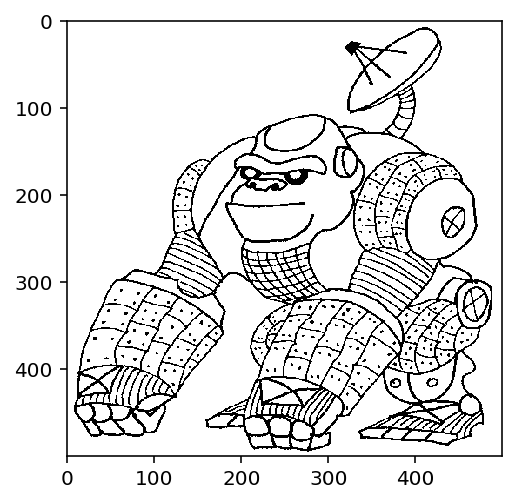

In [11]:
URL = "https://staff.fnwi.uva.nl/m.walter/iit20/gorilla.png"
ORIGINAL_IMAGE = plt.imread(URL)
assert ORIGINAL_IMAGE.shape[0] * ORIGINAL_IMAGE.shape[1] % 8 == 0, "should be multiple of 8 pixels"

# remove alpha channel
if ORIGINAL_IMAGE.shape[2] == 4:
    alpha = ORIGINAL_IMAGE[:, :, 3:]
    ORIGINAL_IMAGE = ORIGINAL_IMAGE[:, :, :3] * alpha + (1 - alpha)

# convert to black & white
WHITE_THRESHOLD = 0.4
ORIGINAL_IMAGE = np.where(ORIGINAL_IMAGE[:, :, :3].max(axis=2) > WHITE_THRESHOLD, 0, 1)

# show the figure
plt.imshow(ORIGINAL_IMAGE, cmap=plt.get_cmap("binary"), interpolation="none")
plt.show()

Reed-Solomon codes use $\mathbb F_q$ as an alphabet.
We will choose $q=257$, so that every symbol can store up 8 bits (1 byte).
The following functions convert between the 2d binary array representing an image and a list of strings over $\mathbb F_q$.

In [12]:
def image_to_bytes(img):
    return np.packbits(img.reshape(-1))


def bytes_to_image(bs):
    return np.unpackbits(bs).reshape(ORIGINAL_IMAGE.shape)


assert np.allclose(bytes_to_image(image_to_bytes(ORIGINAL_IMAGE)), ORIGINAL_IMAGE)

Let us use as block size $N = 256 < q = 257$ and $\alpha=3$ (a generator) and choose $T = 6$ (tolerating up to 3 errors at unknown locations per block). This means that we want to block our message into strings of length $K = 250$.
Thus we obtain the following encoder:

In [ ]:
Q = 257
ALPHA = 3
N = 256
K = 250
T = N - K


def encode_image(img):
    bs = image_to_bytes(img)
    assert len(bs) % K == 0
    x = []
    for i in range(len(bs) // K):
        block = list(bs[K * i : K * (i + 1)])
        enc = encode(block, T=T, alpha=ALPHA, q=Q)
        x += enc
    return x


ENCODED_IMAGE = encode_image(ORIGINAL_IMAGE)

Here is the corresponding decoder.
The option `correct` determined if we apply error correction or not.

In [ ]:
def decode_image(y, correct):
    assert len(y) % N == 0
    bs = []
    for i in range(len(y) // N):
        block = y[N * i : N * (i + 1)]
        if not correct:
            dec = block[T:]
        else:
            try:
                dec = decode_unknown(block, T=T, alpha=ALPHA, q=Q)
            except:
                print(f"failed to correct error in block {i}")
                dec = block[T:]
        dec = [s % Q for s in dec]  # to force in range 0..255
        bs += dec
    return bytes_to_image(np.array(bs, dtype=np.uint8))


assert np.allclose(decode_image(ENCODED_IMAGE, correct=False), ORIGINAL_IMAGE)
assert np.allclose(decode_image(ENCODED_IMAGE, correct=True), ORIGINAL_IMAGE)

Now let's start corrupting the encoded image at 0.5% of the locations.

In [ ]:
CORRUPTED_IMAGE = list(ENCODED_IMAGE)
l = len(CORRUPTED_IMAGE)
np.random.seed(12345)
for _ in range(l // 200):
    loc = np.random.randint(l)
    CORRUPTED_IMAGE[loc] = np.random.randint(Q)

Now let us decode with and without error correction, and see if the Reed-Solomon code does its job!

In [ ]:
fig, row = plt.subplots(1, 4, figsize=(20, 20))

# decode with and without correction
uncorrected = decode_image(CORRUPTED_IMAGE, correct=False)
uncorrected_delta = np.abs(uncorrected - ORIGINAL_IMAGE)
corrected = decode_image(CORRUPTED_IMAGE, correct=True)
corrected_delta = np.abs(corrected - ORIGINAL_IMAGE)

# plot pictures
row[0].set_title("without correction")
row[0].imshow(uncorrected, cmap=plt.get_cmap("binary"), interpolation="none")

row[1].set_title(f"errors (# = {uncorrected_delta.sum()})")
row[1].imshow(1 - uncorrected_delta, cmap=plt.get_cmap("binary"), interpolation="none")

row[2].set_title(f"with correction")
row[2].imshow(corrected, cmap=plt.get_cmap("binary"), interpolation="none")

row[3].set_title(f"remaining errors (# = {corrected_delta.sum()})")
row[3].imshow(1 - corrected_delta, cmap=plt.get_cmap("binary"), interpolation="none")


fig.tight_layout()